In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -*- encoding: utf-8 -*-
import os
import pymetis as metis
from geopy.distance import geodesic
import pickle
import queue
import sys
from tqdm import tqdm
import datetime

In [ ]:
import numpy as np
from typing import List, Set, Tuple

def get_augmented_adjacent_matrix(adj_matrix, subg_node_list, hop):
    subg_nodes = set(subg_node_list)
    
    def get_hop_neighbors(nodes, hop_count):
        if hop_count == 0:
            return nodes
        
        neighbors = set()
        for node in nodes:
            direct_neighbors = set(np.where(adj_matrix[node] > 0)[0])
            neighbors.update(direct_neighbors)
            
        if hop_count > 1:
            neighbors.update(get_hop_neighbors(neighbors - nodes, hop_count - 1))
            
        return neighbors - nodes  
    
    augmented_nodes = set()
    for h in range(1, hop + 1):
        new_nodes = get_hop_neighbors(subg_nodes, h)
        augmented_nodes.update(new_nodes)
    
    final_nodes = list(subg_nodes) + list(augmented_nodes)
    
    n_total = len(final_nodes)
    augmented_matrix = np.zeros((n_total, n_total))
    
    
    for i, node_i in enumerate(final_nodes):
        for j, node_j in enumerate(final_nodes):
            augmented_matrix[i,j] = adj_matrix[node_i, node_j]
    
    return augmented_matrix

# 使用示例
def example_usage():
    # 创建一个示例邻接矩阵
    N = 6
    adj_matrix = np.array([
        [0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0],
        [0, 1, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ])
    
    # 定义子图节点
    subg_node_list = [0, 2]  # 选择节点0和1作为子图
    hop = 2  # 设置hop数为2
    
    # 获取增广邻接矩阵
    aug_matrix, aug_nodes = get_augmented_adjacent_matrix(adj_matrix, subg_node_list, hop)
    
    print("增广后的节点列表:", aug_nodes)
    print("增广邻接矩阵:")
    print(aug_matrix)

    aug_matrix, aug_nodes = get_augmented_adjacent_matrix(adj_matrix, subg_node_list, 1)
    
    print("增广后的节点列表:", aug_nodes)
    print("增广邻接矩阵:")
    print(aug_matrix)


example_usage()

增广后的节点列表: [0, 2, 1, 3, 4]
增广邻接矩阵:
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]
增广后的节点列表: [0, 2, 1, 4]
增广邻接矩阵:
[[0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [11]:
import numpy as np
from torch.utils.data import Dataset

# Implement the SlidingDataset class
class SlidingDataset(Dataset):
    def __init__(self, data, batch_size, window_size, stride, sample_size, logger):
        self.data = data
        self.stride = stride
        self.batch_size = batch_size
        self.sample_size = sample_size
        self.window_size = window_size

        self.num_samples = data.shape[0] // sample_size
        self.windows_per_sample = (sample_size - window_size) // stride + 1
        self.total_batches = self.num_samples * (self.windows_per_sample - batch_size +1)

        logger.info('Windows per sample: ' + str(self.windows_per_sample - batch_size +1))
        logger.info('Total batches: ' + str(self.total_batches))

    def __len__(self):
        return self.total_batches

    def __getitem__(self, idx):

        sample_idx = (idx ) // (self.windows_per_sample - batch_size +1)
        window_start_idx = (idx ) % (self.windows_per_sample - batch_size +1)

        sample_start_idx = sample_idx * self.sample_size
        sample_data = self.data[sample_start_idx:sample_start_idx + self.sample_size]


        batch_samples = [
            sample_data[window_start_idx + i * self.stride: window_start_idx + i * self.stride + self.window_size]
            for i in range(self.batch_size)
        ]
        
        return np.stack(batch_samples, axis=0), sample_idx


# Simple logger for testing
class Logger:
    def info(self, msg):
        print(msg)

# Test data and initialization
data = np.arange(1, 101)  # data from 1 to 100
batch_size = 3
window_size = 5
stride = 1
sample_size = 10
logger = Logger()

dataset = SlidingDataset(data, batch_size, window_size, stride, sample_size, logger)

# Test the dataset class
for idx in range(len(dataset)):
    batch, sample_idx = dataset[idx]
    print(f"Batch {idx}:\n{batch}\nSample Index: {sample_idx}")


Windows per sample: 4
Total batches: 40
Batch 0:
[[1 2 3 4 5]
 [2 3 4 5 6]
 [3 4 5 6 7]]
Sample Index: 0
Batch 1:
[[2 3 4 5 6]
 [3 4 5 6 7]
 [4 5 6 7 8]]
Sample Index: 0
Batch 2:
[[3 4 5 6 7]
 [4 5 6 7 8]
 [5 6 7 8 9]]
Sample Index: 0
Batch 3:
[[ 4  5  6  7  8]
 [ 5  6  7  8  9]
 [ 6  7  8  9 10]]
Sample Index: 0
Batch 4:
[[11 12 13 14 15]
 [12 13 14 15 16]
 [13 14 15 16 17]]
Sample Index: 1
Batch 5:
[[12 13 14 15 16]
 [13 14 15 16 17]
 [14 15 16 17 18]]
Sample Index: 1
Batch 6:
[[13 14 15 16 17]
 [14 15 16 17 18]
 [15 16 17 18 19]]
Sample Index: 1
Batch 7:
[[14 15 16 17 18]
 [15 16 17 18 19]
 [16 17 18 19 20]]
Sample Index: 1
Batch 8:
[[21 22 23 24 25]
 [22 23 24 25 26]
 [23 24 25 26 27]]
Sample Index: 2
Batch 9:
[[22 23 24 25 26]
 [23 24 25 26 27]
 [24 25 26 27 28]]
Sample Index: 2
Batch 10:
[[23 24 25 26 27]
 [24 25 26 27 28]
 [25 26 27 28 29]]
Sample Index: 2
Batch 11:
[[24 25 26 27 28]
 [25 26 27 28 29]
 [26 27 28 29 30]]
Sample Index: 2
Batch 12:
[[31 32 33 34 35]
 [32 33 34 35 3

In [ ]:
available_bits = torch.Tensor([0,1,2,1],[0,1,2,1]]).unsqueeze(0)
(available_bits.sum(axis=1) == 0).shape

torch.Size([1, 4])

In [46]:
import threading
import torch

import threading
import torch
from torch.utils.data import Dataset

class SlidingDataset(Dataset):
    def __init__(self, data, batch_size, window_size, stride):
        self.data = data
        self.stride = stride
        self.batch_size = batch_size
        self.window_size = window_size
        self.total_samples = (data.shape[0] - window_size) + 1
        self.total_batches = (self.total_samples - batch_size) + 1

    def __len__(self):
        return self.total_batches

    def __getitem__(self, idx):
        batch_start_idx = idx * self.stride
        batch_samples = []
        for i in range(self.batch_size):
            start_idx = batch_start_idx + i * self.stride
            end_idx = start_idx + self.window_size
            if end_idx <= self.data.shape[0]:  # Ensure slice is within bounds
                batch_samples.append(self.data[start_idx:end_idx])
            else:
                # Padding to maintain consistent shapes if we reach the end of data
                pad_size = end_idx - self.data.shape[0]
                batch_samples.append(
                    torch.cat([self.data[start_idx:], torch.zeros(pad_size, *self.data.shape[1:])])
                )
        return torch.stack(batch_samples, dim=0)

class MyDataLoader:
    def __init__(self, data, batch_size, stride, seq_len, pred_len, drop_last=True):
        self.datasets = SlidingDataset(data, batch_size, seq_len + pred_len, stride)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.n_batch = len(self.datasets) - 1 if drop_last else len(self.datasets)

    def get_iterator(self, num_threads=4):
        self.current_ind = 0
        def _wrapper():
            while self.current_ind < self.n_batch:
                threads = []
                results = [None] * num_threads

                def worker(thread_idx):
                    local_idx = self.current_ind + thread_idx
                    if local_idx < self.n_batch:  # Prevent out-of-range access
                        item = self.datasets[local_idx]
                        results[thread_idx] = (item[:, :self.seq_len], item[:, self.seq_len:, :, :1])

                for i in range(num_threads):
                    thread = threading.Thread(target=worker, args=(i,))
                    thread.start()
                    threads.append(thread)

                for thread in threads:
                    thread.join()

                for result in results:
                    if result is not None:
                        yield result

                self.current_ind += num_threads
                print(self.current_ind)
        return _wrapper()


# 示例数据
T, N, D = 1000, 1, 1  # 假设 T=100, N=10, D=5
data = torch.arange(1000).unsqueeze(-1).unsqueeze(-1)

# 参数设置
window_size = 4  # 每个样本窗口的长度 t
batch_size = 12  # batch size
stride = 1  # 窗口滑动步长

# 创建数据集和 DataLoader
# dataset = SlidingWindowBatchDataset(data, window_size=window_size, stride=stride, batch_size= batch_size)
dataloader = MyDataLoader(data, batch_size=batch_size, stride=stride, seq_len= 2, pred_len= 2)

# 检查 DataLoader 输出
for i, batch in enumerate(dataloader.get_iterator()):
    # print(f"Batch {i+1}: {batch[0].shape}")
    # print(i,batch[0],batch[1])
    # print(i,'hist', batch[0])
    # print(i,'pred',batch[1])
    pass
    # batch 的形状应为 (batch_size, window_size, N, D)

4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104
108
112
116
120
124
128
132
136
140
144
148
152
156
160
164
168
172
176
180
184
188
192
196
200
204
208
212
216
220
224
228
232
236
240
244
248
252
256
260
264
268
272
276
280
284
288
292
296
300
304
308
312
316
320
324
328
332
336
340
344
348
352
356
360
364
368
372
376
380
384
388
392
396
400
404
408
412
416
420
424
428
432
436
440
444
448
452
456
460
464
468
472
476
480
484
488
492
496
500
504
508
512
516
520
524
528
532
536
540
544
548
552
556
560
564
568
572
576
580
584
588
592
596
600
604
608
612
616
620
624
628
632
636
640
644
648
652
656
660
664
668
672
676
680
684
688
692
696
700
704
708
712
716
720
724
728
732
736
740
744
748
752
756
760
764
768
772
776
780
784
788
792
796
800
804
808
812
816
820
824
828
832
836
840
844
848
852
856
860
864
868
872
876
880
884
888
892
896
900
904
908
912
916
920
924
928
932
936
940
944
948
952
956
960
964
968
972
976
980
984
988


In [5]:
import torch
a = list(range(0,10))
a.extend(list(range(2,5)))
a

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4]

In [47]:
import threading
import torch

class SlidingDataset(Dataset):
    def __init__(self, data, batch_size, window_size, stride):
        self.data = data
        self.stride = stride
        self.batch_size = batch_size
        self.window_size = window_size
        self.total_samples = (data.shape[0] - window_size) + 1  
        self.total_batches = (self.total_samples - batch_size) + 1

    def __len__(self):
        return self.total_batches

    def __getitem__(self, idx):
        batch_start_idx = idx * self.stride
        batch_samples = [
            self.data[batch_start_idx + i * self.stride : batch_start_idx + i * self.stride + self.window_size]
            for i in range(self.batch_size)
        ]
        return torch.stack(batch_samples, dim=0)

class MyDataLoader:
    def __init__(self, data, batch_size, stride, seq_len, pred_len, drop_last=True):
        self.datasets = SlidingDataset(data, batch_size, seq_len + pred_len, stride)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.n_batch = len(self.datasets) - 1 if drop_last else len(self.datasets)
        # TODO 
        # accelerate data loading with thread
        
    def get_iterator(self,):
        self.current_ind = 0

        def _wrapper():
            while self.current_ind< self.n_batch:

                item = self.datasets.__getitem__(self.current_ind)
                yield (item[:,:self.seq_len], item[:,self.seq_len:,:,:1])
                self.current_ind += 1
                
        return _wrapper()



# 示例数据
T, N, D = 100, 1, 1  # 假设 T=100, N=10, D=5
data = torch.arange(100).unsqueeze(-1).unsqueeze(-1)

# 参数设置
window_size = 4  # 每个样本窗口的长度 t
batch_size = 4  # batch size
stride = 1  # 窗口滑动步长

# 创建数据集和 DataLoader
# dataset = SlidingWindowBatchDataset(data, window_size=window_size, stride=stride, batch_size= batch_size)
dataloader = MyDataLoader(data, batch_size=batch_size, stride=stride, seq_len= 2, pred_len= 2)

# 检查 DataLoader 输出
for i, batch in enumerate(dataloader.get_iterator()):
    # print(f"Batch {i+1}: {batch[0].shape}")
    # print(i,batch[0],batch[1])
    print(i,'hist', batch[0])
    print(i,'pred',batch[1])
    # batch 的形状应为 (batch_size, window_size, N, D)


0 hist tensor([[[[0]],

         [[1]]],


        [[[1]],

         [[2]]],


        [[[2]],

         [[3]]],


        [[[3]],

         [[4]]]])
0 pred tensor([[[[2]],

         [[3]]],


        [[[3]],

         [[4]]],


        [[[4]],

         [[5]]],


        [[[5]],

         [[6]]]])
1 hist tensor([[[[1]],

         [[2]]],


        [[[2]],

         [[3]]],


        [[[3]],

         [[4]]],


        [[[4]],

         [[5]]]])
1 pred tensor([[[[3]],

         [[4]]],


        [[[4]],

         [[5]]],


        [[[5]],

         [[6]]],


        [[[6]],

         [[7]]]])
2 hist tensor([[[[2]],

         [[3]]],


        [[[3]],

         [[4]]],


        [[[4]],

         [[5]]],


        [[[5]],

         [[6]]]])
2 pred tensor([[[[4]],

         [[5]]],


        [[[5]],

         [[6]]],


        [[[6]],

         [[7]]],


        [[[7]],

         [[8]]]])
3 hist tensor([[[[3]],

         [[4]]],


        [[[4]],

         [[5]]],


        [[[5]],

    

In [29]:
dataset.__getitem__(0)

torch.Size([4, 3, 1, 1]) torch.Size([3, 1, 1])


tensor([[[[0]],

         [[1]],

         [[2]]],


        [[[1]],

         [[2]],

         [[3]]],


        [[[2]],

         [[3]],

         [[4]]],


        [[[3]],

         [[4]],

         [[5]]]])

In [15]:
dataset.__getitem__(1)

torch.Size([4, 3, 1, 1]) torch.Size([3, 1, 1])


tensor([[[[1]],

         [[2]],

         [[3]]],


        [[[2]],

         [[3]],

         [[4]]],


        [[[3]],

         [[4]],

         [[5]]],


        [[[4]],

         [[5]],

         [[6]]]])

In [9]:
batch.shape

torch.Size([3, 3, 3, 1, 1])

In [2]:
edge_infos = pd.read_csv('data/chengdu/edges.csv')
edge_infos

,Unnamed: 0,osmid,highway,oneway,length,name,geometry,lanes,bridge,ref,junction,maxspeed,tunnel,u,v,key,fid
0,0,28623889,unclassified,False,20.517,NaN,"LINESTRING (104.100294 30.7147948, 104.1000959...",NaN,NaN,NaN,NaN,NaN,NaN,288416374,1815728532,0,0
1,1,137133120,primary,True,143.316,昭觉寺南路,"LINESTRING (104.100294 30.7147948, 104.1007853...",NaN,NaN,NaN,NaN,NaN,NaN,288416374,3541376393,0,1
2,2,28623889,unclassified,False,173.857,NaN,"LINESTRING (104.100294 30.7147948, 104.1015994...",NaN,NaN,NaN,NaN,NaN,NaN,288416374,314655436,0,2
3,3,184255152,primary,True,277.305,解放路一段,"LINESTRING (104.083862 30.6898358, 104.0828949...",3,NaN,NaN,NaN,NaN,NaN,288416379,1159231411,0,3
4,4,184296328,tertiary,False,318.437,平福巷,"LINESTRING (104.083862 30.6898358, 104.086253 ...",NaN,NaN,NaN,NaN,NaN,NaN,288416379,1947583836,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6397,6397,887890886,secondary,True,13.047,王贾路,"LINESTRING (104.066007 30.7199718, 104.0660103...",NaN,NaN,NaN,NaN,NaN,NaN,8255138229,8255138230,0,6397
6398,6398,92408253,primary,True,11.466,中环路洞子口路段,"LINESTRING (104.0660103 30.7200891, 104.065913...",NaN,NaN,NaN,NaN,NaN,NaN,8255138230,1902099198,0,6398
6399,6399,887890886,secondary,True,65.922,王贾路,"LINESTRING (104.0660103 30.7200891, 104.066022...",NaN,NaN,NaN,NaN,NaN,NaN,8255138230,8255138232,0,6399
6400,6400,887890887,secondary,True,57.625,王贾路,"LINESTRING (104.0659598 30.7206667, 104.065913...",NaN,NaN,NaN,NaN,NaN,NaN,8255138232,1902099198,0,6400


In [165]:
folder_path = 'data/chengdu/300/'

file_list = [file for file in os.listdir(folder_path) if file.startswith('match')]
file_list.sort()

sets = []
for edge_csv in tqdm(file_list):
    road_info = pd.read_csv(folder_path+edge_csv)

    sets.append(road_info)

df_avg_count = pd.concat(sets)
df_avg_count = df_avg_count.groupby(['link', 'time']).count().reset_index()
df_avg_count = df_avg_count[['link','time','speed']]


min_time = df_avg_count['time'].min()
max_time = df_avg_count['time'].max()

num_minutes = round((max_time - min_time) / 300) + 1
matrix = np.zeros((6402, num_minutes), dtype=int)

time_offsets = round((df_avg_count['time'] - min_time) / 300)

matrix[df_avg_count['link'], time_offsets.astype(int)] += df_avg_count['speed']
# count_matrix
np.save('data/chengdu/raw/cnt_300.npy',matrix)


100%|██████████| 61/61 [06:32<00:00,  6.44s/it]


In [ ]:
df_avg = road_info.groupby(['link', 'time'])['speed'].mean().reset_index()
df_avg = df_avg[df_avg['speed']>0]

df_avg['time'] = pd.to_datetime(df_avg['time'], unit='s')

min_time = df_avg['time'].min()
max_time = df_avg['time'].max()

num_minutes = int((max_time - min_time).total_seconds() / 60) + 1
matrix = np.zeros((6402, num_minutes))

for link in range(6402):
    try:
        ty = edge_infos.loc[link, 'highway']
    except Exception as err:
        ty = "none"

    default_speed = speedlimit_dict.get(ty, 50) / 3.6 * 0.7

    matrix[link] = default_speed


time_offsets = (df_avg['time'] - min_time).dt.total_seconds() // 60

matrix[df_avg['link'], time_offsets.astype(int)] = df_avg['speed']

matrix

In [9]:
adj_matrix = np.zeros((6402, 6402))

# 填充邻接矩阵
for index, row in edge_infos.iterrows():

    u_idx = row['u']
    v_idx = row['v']

    sub = edge_infos[(edge_infos['u']==u_idx) | (edge_infos['u']==v_idx) | (edge_infos['v']==u_idx) | (edge_infos['v']==v_idx)]
    adj_matrix[index,sub.fid.values] = 1
    adj_matrix[sub.fid.values,index] = 1


# 打印邻接矩阵
print(adj_matrix)
np.save('data/chengdu/cnt_300_adj.npy', adj_matrix)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


(array([  33.,  151., 1095.,  629.,  934., 2322.,  153.,  891.,  190.,
           4.]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <BarContainer object of 10 artists>)

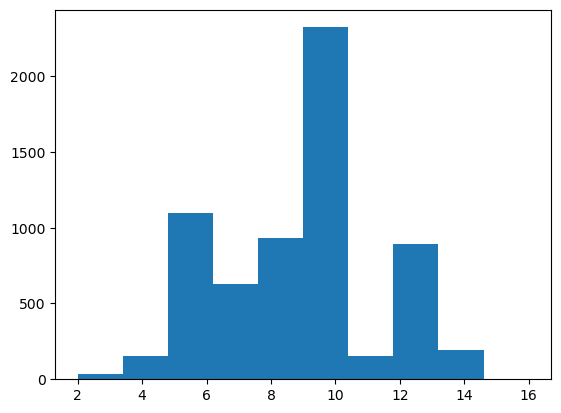

In [110]:
degree = adj_matrix.sum(axis=0)
plt.hist(degree)

In [3]:
cnt_60 = np.load('data/chengdu/raw/cnt_60.npy')
cnt_300 = np.load('data/chengdu/raw/cnt_300.npy')

In [5]:
cnt_300.shape

(6402, 17568)

In [7]:
short_cnt_300 = cnt_300[:1500]

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from dtw import accelerated_dtw

data = short_cnt_300

N = short_cnt_300.shape[0]
def calculate_correlation(x, y, lag=0):
    if lag > 0:
        return pearsonr(x[lag:], y[:-lag])[0]
    elif lag < 0:
        return pearsonr(x[:lag], y[-lag:])[0]
    else:
        return pearsonr(x, y)[0]

def granger_test(x, y, max_lag=5):
    df = pd.DataFrame({'x': x, 'y': y})
    results = grangercausalitytests(df[['x', 'y']], max_lag, verbose=False)
    return results

def calculate_dtw(x, y):
    dist, _, _, _ = accelerated_dtw(x, y, dist='euclidean')
    return dist

def hop_neighbors(adj_matrix, hop):
    hop_matrix = np.linalg.matrix_power(adj_matrix, hop)
    hop_matrix[hop_matrix > 1] = 1  
    return hop_matrix

# 选择不同的评价方法
def evaluate_correlations(data, adj_matrix, lag_range, max_hop):
    correlations = []
    for hop in range(1, max_hop + 1):
        hop_matrix = hop_neighbors(adj_matrix, hop)
        
        for lag in lag_range:
            for i in range(N):
                for j in range(i + 1, N):  
                    if hop_matrix[i, j] == 1:  
                        x = data[i]
                        y = data[j]

                        pearson_corr = calculate_correlation(x, y, lag)
  
                        granger_result = granger_test(x, y, max_lag=lag+1)

                        dtw_distance = calculate_dtw(x, y)

                        correlations.append({
                            'route_i': i,
                            'route_j': j,
                            'lag': lag,
                            'hop': hop,
                            'pearson_corr': pearson_corr,
                            'granger_causality': granger_result,
                            'dtw_distance': dtw_distance
                        })
    return correlations

lag_range = range(0, 3)  
max_hop = 3  

correlation_results = evaluate_correlations(data, adj_matrix, lag_range, max_hop)

correlation_pd = pd.DataFrame(correlation_results)

/home_nfs/yinfeng/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home_nfs/yinfeng/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home_nfs/yinfeng/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home_nfs/yinfeng/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home_nfs/yinfeng/miniconda3/envs/jupyter/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


InfeasibleTestError: The x values include a column with constant values and so the test statistic cannot be computed.